In [2]:
import numpy as np  # import numpy package (abbreviation stands for Numerical Python)
import matplotlib.pyplot as plt  # we plot graphs with this library
from scipy.integrate import odeint
from scipy.linalg import eig, inv
from numba import jit, njit, prange

from matplotlib import cm
import matplotlib as mpl
# from numpy.linalg import *
%matplotlib inline

In [552]:
R = 8.314

def populations(T, dH, dS):
    K = np.exp(-dH/(R * T) + dS / R)
    return 1/(1 + K), K/(1+K)

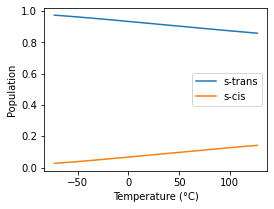

In [553]:
T = np.linspace(200, 400, 300)

pop = populations(T, 5.98209e3, 0)

plt.rcParams['figure.figsize'] = [4, 3]

plt.plot(T  - 273, pop[0], label='s-trans')
plt.plot(T - 273, pop[1], label='s-cis')

plt.xlabel("Temperature (°C)")
plt.ylabel("Population")

plt.legend()

plt.savefig("equlibirium.svg")




In [80]:
2 * np.sqrt(2*np.log(2))

2.3548200450309493

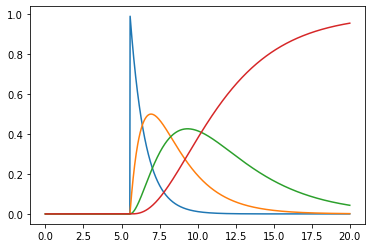

In [78]:
# populations(25 + 273.15, 5.98209e3)

k1, k2, k3, k4  = 1, 0.5, 0.3, 0.003

ks = np.asarray([k1, k2, k3, k4])

# K = np.asarray([[-k1, 0 ], 
#                 [k1, -k2]])async


K = np.asarray([[-k1, 0 ], 
                [0, -k2]])

K = np.asarray([[-k1, 0 ], 
                [k1, -k2]])

K = np.asarray([[-k1, 0 , 0, 0], 
                [k1, -k2, 0, 0], 
                [0, k2, -k3, 0],
                [0, 0, k3, 0]])


# def simul(t, mu, L, A):
#     C = np.exp(times[:, None] * L[None, :])
#     return C.dot(A)


def anal(times, j):
    return odeint(lambda c, t: K.dot(c), j, times)

mu = np.linspace(0, 10, 10)

L, Q = np.linalg.eig(K)
Q_inv = np.linalg.inv(Q)

j = np.zeros(K.shape[0])
j[0] = 1

A2_T = Q @ np.diag(Q_inv.dot(j))

times = np.linspace(0, 20, 1000)

tt = times[None, :, None] - mu[:, None, None]
C = np.heaviside(tt, 1) * np.exp(tt * L[None, None, :])
C = C.dot(A2_T.T)

plt.plot(times, C[5])
# plt.plot(times, anal(times, j), ls='--')
plt.show()
    


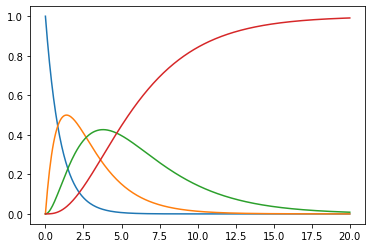

In [5]:
k1, k2, k3, k4  = 1, 0.5, 0.3, 0

# K = np.asarray([[-k1, 0 ], 
#                 [k1, -k2]])async

K = np.asarray([[-k1, 0 , 0], 
                [k1, -k2, 0], 
                [0, k2, -k3]])

K = np.asarray([[-k1, 0 , 0, 0], 
                [k1, -k2, 0, 0], 
                [0, k2, -k3, 0],
                [0, 0, k3, -k4]])

c0 = np.asarray([1.0, 0, 0, 0])

def simul_an(times, c0, K):
    L, Q = np.linalg.eig(K)
    Q_inv = np.linalg.inv(Q)
    
    n = times.shape[0]
    
    traces = np.exp(times[:, None] * L)
    
    # n x n x n
    outers = Q.T[..., None] * Q_inv[:, None, :]
    res = traces[..., None, None] * outers[None, ...]
    summed = res.sum(axis=1)
    
    return summed.dot(c0)


@njit(fastmath=True)
def simul_an_numba(times, c0, K):
    L, Q = np.linalg.eig(K)
    Q_inv = np.linalg.inv(Q)
    
    n = times.shape[0]
    Kn = K.shape[0]
    
    traces = np.exp(times.reshape((n, 1)) * L)
#     outers = Q.T.reshape((Kn, Kn, 1)) * Q_inv.reshape((Kn, 1, Kn))
#     temp = np.zeros_like(outers)

#     for i in prange(n):
        
#         for j in range(Kn):
#             temp[j] = traces[i][j] * outers[j]
            
#         traces[i] = temp.sum(axis=0).dot(c0)
        

    for i in prange(n):
        traces[i] = Q.dot(np.diag(traces[i])).dot(Q_inv).dot(c0)
        
    return traces

def simul_ode(times, c0, K):
    return odeint(lambda c, t: K.dot(c), c0, times)
    

times = np.linspace(0, 20, 300)

@njit(fastmath=True, parallel=True)
def a(tensor):
    
    eigs = np.zeros((tensor.shape[0], tensor.shape[1]))
    vectors = np.zeros((tensor.shape[0], tensor.shape[1], tensor.shape[1]))
    vectors_inv = np.zeros((tensor.shape[0], tensor.shape[1], tensor.shape[1]))
    
    for i in range(tensor.shape[0]):
#         w, vr = eig(K, left=False, right=True, check_finite=False)
        w, wr = np.linalg.eig(tensor[i])
        eigs[i] = w
        vectors[i] = wr
        vectors_inv[i] = np.linalg.inv(wr)
    return eigs, vectors, vectors_inv

#         vr_inv = np.linalg.inv(vr)

tensor = np.tile(K, (400, 1, 1))




# tensor = np.random.random((400, 3, 3))


# %timeit vals, vects, vectors_inv = a(tensor)


# w, vr = eig(K, left=False, right=True, check_finite=False)
# L, Q = np.linalg.eig(K)

# vr_inv = np.linalg.inv(vr)



# vl

# np.isclose(K, vr @ np.real(np.diag(w)) @ vr_inv)
# vr @ np.real(np.diag(w)) @ vr_inv



# vl @ np.real(np.diag(w)) @ vr.T

# Q_inv = np.linalg.inv(Q)

# Q[:, 0, None] * Q_inv[None, 0]
# Q[:, 1, None] * Q_inv[None, 1]
# Q[:, 2, None] * Q_inv[None, 2]

# outers = Q.T[:, :, None] * Q_inv[:, None, :]
# # Q.T[:, :, None] * Q_inv[None, ...]
# # outers * np.exp(L)

# traces = np.exp(times[:, None] * L)
# res = traces[..., None, None] * outers[None, ...]
# res.shape

# summed = res.sum(axis=1)
# # summed.shape
# # print(summed.dot(c0))
# summed[99].dot(c0)

# traces = np.exp(times[:, None] * c0)

# res = traces[:, None, :, None] * outers[None, ...]

# summed = res.sum(axis=1)
# summed.dot(c0[:, None])

tr_ode = simul_ode(times, c0, K)
# tr_an = simul_an_numba(times, c0, K)

plt.plot(times, tr_ode)
plt.show()

In [635]:
A = np.asarray([[1, 2], 
                [3, 4]])

B = np.asarray([1, 2])


C = np.asarray([[1, 2], 
                [3, 4]])




B[0] * A[:, 0, None] * C[None, 0] + B[1] * A[:, 1, None] * C[None, 1]




array([[13, 18],
       [27, 38]])

In [111]:
A @ C

array([[ 7, 10],
       [15, 22]])

In [103]:
A @ B @ C

array([[13, 18],
       [27, 38]])

In [106]:
A

array([[1, 2],
       [3, 4]])

In [107]:
B

array([[1, 0],
       [0, 2]])

In [108]:
C

array([[1, 2],
       [3, 4]])